# Определение наиболее выгодного региона нефтедобычи

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from numpy.random import RandomState
from scipy import stats as st
from scipy.stats import t

In [2]:
#откроем файлы с данными
df_1 = pd.read_csv('/datasets/geo_data_0.csv') #первый регион
df_2 = pd.read_csv('/datasets/geo_data_1.csv') #второй регион
df_3 = pd.read_csv('/datasets/geo_data_2.csv') #третий регион

In [3]:
#изучим, полученные данные
display(df_1.head())
display(df_2.head())
display(df_3.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [4]:
#напишем универсальную функцию для изучения данных
def uni_function(function):
    display(function.info())
    display(function.isna().sum())
    display(function.describe())
    display(function.duplicated().sum())
uni_function(df_1) #первый регион

In [5]:
uni_function(df_2) #второй регион

In [6]:
uni_function(df_3) #третий регион

**Вывод**    
Как мы видим, каждый столбец имеет правильный тип данных, пропусков и дубликатов нет. Знаяения среднего арифметического близки к значениям медианы, значит значительных выбросов в данных нет. Данные чистые и готовы к дальнейшему анализу.

### Проверка корреляции

<AxesSubplot:>

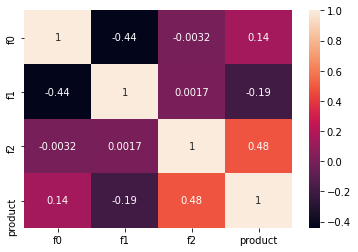

In [7]:
sns.heatmap(df_1.corr(), annot = True) #первый регион

<AxesSubplot:>

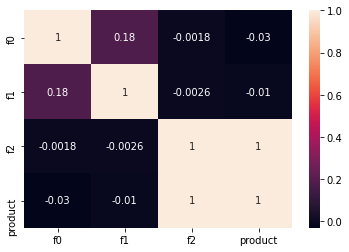

In [8]:
sns.heatmap(df_2.corr(), annot = True) #второй регион

<AxesSubplot:>

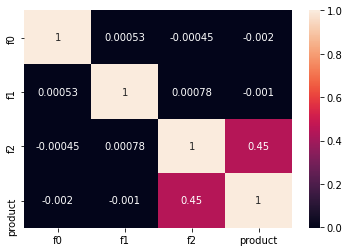

In [9]:
sns.heatmap(df_3.corr(), annot = True) #третий регион

**Вывод**    
Проверка корреляции является методом определения линейной зависимости между параметрами. С его помощью можно определить какие функции больше всего влияют на целевую переменную, и в тоже время для прогнозированя этой целевой переменной.    
Исходя из полученных данных, мы видим, что среди данных первого региона взаимосвязи не наблюдается. В данных второго региона мы видим, что взаимосвязь признака f2 и объема запасов в скважине(product) равна единице, а значит корреляция является 100%. Для третьего региона также наблюдается взаимосвязь между параметром f2 и объемом запасов в скважине.

Т.к. столбец id в условиях данной задачи не несет в себе никой нужной информации, мы можем его удалить.

In [10]:
df_1 = df_1.drop(['id'], axis=1)
df_2 = df_2.drop(['id'], axis=1)
df_3 = df_3.drop(['id'], axis=1)
display(df_1.head(), df_2.head(), df_3.head())

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


## Обучение и проверка модели

### Разбивка данных на выборки

In [11]:
#создадим функцию для работы с 3-мя датасетами
def region(region_number):
    features = region_number.drop(['product'], axis=1) # извлекаем признаки
    target = region_number['product'] # извлекаем целевой признак
    #print(features.shape)
    #разделим данные на обучающую и валидационную выборки 
    features_train, features_valid, target_train, target_valid = train_test_split(
            features, target, test_size=0.25, random_state = 12345)
    #применим метод масштабирования — стандартизация данных
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    return features_train, features_valid, target_train, target_valid
warnings.filterwarnings('ignore')

In [12]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = region(df_1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = region(df_2)
features_train_3, features_valid_3, target_train_3, target_valid_3 = region(df_3)

### Обучение модели и предсказания на валидационной выборке

In [13]:
def teaching(features_train, features_valid, target_train, target_valid):
    model = LinearRegression() 
    model.fit(features_train, target_train) #обучим модель на тренировочной выборке
    predictions_valid = pd.Series(model.predict(features_valid)) # получим предсказания модели на валидационной выборке
    
    rmse = (mean_squared_error(target_valid, predictions_valid))**0.5 # посчитаем значение метрики RMSE на валидационной выборке
    raw_mean = predictions_valid.mean() #средний запас
    
    return predictions_valid, rmse, raw_mean

In [14]:
#определим предсказание модеоли,RMSE модели и средний запас предсказанного сырья для каждого региона
predictions_valid_1, rmse_1, raw_mean_1 = teaching(features_train_1, features_valid_1, target_train_1, target_valid_1)
predictions_valid_2, rmse_2, raw_mean_2 = teaching(features_train_2, features_valid_2, target_train_2, target_valid_2)
predictions_valid_3, rmse_3, raw_mean_3 = teaching(features_train_3, features_valid_3, target_train_3, target_valid_3)

In [15]:
print(f'Cредний запас предсказанного сырья региона №1 составляет {raw_mean_1}') 
print(f'Cредний запас предсказанного сырья региона №2 составляет {raw_mean_2}')
print(f'Cредний запас предсказанного сырья региона №3 составляет {raw_mean_3}')

Cредний запас предсказанного сырья региона №1 составляет 92.59256778438035
Cредний запас предсказанного сырья региона №2 составляет 68.728546895446
Cредний запас предсказанного сырья региона №3 составляет 94.96504596800489


In [16]:
print(f'Значение RMSE региона №1 составляет {rmse_1}') 
print(f'Значение RMSE региона №2 составляет {rmse_2}') 
print(f'Значение RMSE региона №3 составляет {rmse_3}') 

Значение RMSE региона №1 составляет 37.5794217150813
Значение RMSE региона №2 составляет 0.893099286775617
Значение RMSE региона №3 составляет 40.02970873393434


In [17]:
#сравним полученные данные с реальными
print(f'Cредний запас исходного сырья региона №1 составляет {target_valid_1.mean()}') 
print(f'Cредний запас исходного сырья региона №2 составляет {target_valid_2.mean()}')
print(f'Cредний запас исходного сырья региона №3 составляет {target_valid_3.mean()}')

Cредний запас исходного сырья региона №1 составляет 92.07859674082927
Cредний запас исходного сырья региона №2 составляет 68.72313602435997
Cредний запас исходного сырья региона №3 составляет 94.88423280885438


**Вывод**    
Исходя из полученных данным, мы можем сделать вывод о том, что:
1. все модели имеют малый разброс данных, на это указывают небольшие отличия предстазанных результов от реальных.
2. наилучшей моделью является модель второго региона. У данной модели минимальное значение RMSE, значит данная модель лучше всех описывает данные. Вероятно, на полученные данные также оказывает влияние и то, что во втором регионе у признака f2 и объёма запасов в скважине присутствует 100% линейная зависимость.


## Подготовка к расчёту прибыли

3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.    
3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.    
3.3. Напишите выводы по этапу подготовки расчёта прибыли.    


### Сохраним важные для расчетов переменные

In [18]:
total_points = 500 #исследуемые точки
best_points = 200 #лучшие из исследуемых точек(200 лучших скважин)
income_per_barrel = 450 #доход с одного барреля
unit_income = 0.45 #Доход с каждой 1тыс. баррелей в млн рублей
budget = 10000 #Бюджет на разработку скважин в регионе в млн рублей
loss_probability = 0.025 #вероятность убытков

### Расчет объема сырья для безубыточной разработки

In [19]:
#определим бюджет на разработку одной скважины, млн рублей
development_budget = budget/best_points 
#объем сырья для безубыточной разработки скважины
volume_of_raw_materials = development_budget/unit_income 
print(f'Объем сырья для безубыточной разработки скважины в 1 тыс.баррелей составляет {volume_of_raw_materials:.1f}') 

Объем сырья для безубыточной разработки скважины в 1 тыс.баррелей составляет 111.1


### Сравним полученный  объем сырья со средним запасом в каждом регионе

In [20]:
volume_difference_1 = (volume_of_raw_materials-raw_mean_1)/volume_of_raw_materials
volume_difference_2 = (volume_of_raw_materials-raw_mean_2)/volume_of_raw_materials
volume_difference_3 = (volume_of_raw_materials-raw_mean_3)/volume_of_raw_materials
print(f'Разница полученного объема сырья и среднего запаса региона №1 составляет {volume_difference_1:.1%}') 
print(f'Разница полученного объема сырья и среднего запаса региона №2 составляет {volume_difference_2:.1%}') 
print(f'Разница полученного объема сырья и среднего запаса региона №3 составляет {volume_difference_3:.1%}') 

Разница полученного объема сырья и среднего запаса региона №1 составляет 16.7%
Разница полученного объема сырья и среднего запаса региона №2 составляет 38.1%
Разница полученного объема сырья и среднего запаса региона №3 составляет 14.5%


Исходя из полученных данных мы можем сделать вывод о том, что ни один из регионов не может обеспечить безубыточную разработку. Мы видим, что самым перспективным районом сейчас является регион №3. Там нехватка сырья для безубычной работы составляет 14,5%.

## Расчёт прибыли и рисков 

Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:    
4.1. Выберите скважины с максимальными значениями предсказаний.    
4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.    
4.3. Рассчитайте прибыль для полученного объёма сырья.    

In [21]:
def income_calc(target_valid, predictions_valid):
    well_best_pred = predictions_valid.sort_values(ascending = False).head(200) #скважины с максимальными значениями предсказаний объема сырья
    target_best = target_valid.reset_index(drop=True)[well_best_pred.index] #целевые значения, соответсвующие максимальным значениям предсказаний
    income_for_raw_materials = target_best.sum() * unit_income #доход от полученного объема сырья
    return income_for_raw_materials   
income_calc(target_valid_1, predictions_valid_1)
profit_1 = income_calc(target_valid_1, predictions_valid_1) - budget
profit_2 = income_calc(target_valid_2, predictions_valid_2) - budget
profit_3 = income_calc(target_valid_3, predictions_valid_3) - budget
print(f'''Прибыль для полученного объема сырья: 
- для региона №1 - {profit_1:.1f} млн.рублей,
- для региона №2 - {profit_2:.1f} млн.рублей,
- для региона №3 - {profit_3:.1f} млн.рублей.
''') 

Прибыль для полученного объема сырья: 
- для региона №1 - 3320.8 млн.рублей,
- для региона №2 - 2415.1 млн.рублей,
- для региона №3 - 2710.3 млн.рублей.



**Вывод**    
Изучив 200 лучших из исследуемых точек, мы выяснили, что самым прибыльным является регион №1, далее идет регион №3 и последним по прибыльности является регион №2.

## Расчет рисков и прибыли для каждого региона

5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.     
5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.     
5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.    

Напишем функцию, которая отберет 200 лучших точек и посчитает доход с каждой из них.

In [22]:
def revenue (target_valid, predictions_valid, best_points):
    pred_choice = predictions_valid.sort_values(ascending=False).head(200) # сортируем скважины по значениям их предсказаний
    # определяем верные значения для отобранных случайных скважин и берем только нужное количество
    target_choice = target_valid[pred_choice.index][:200] #целевые значения, соответсвующие максимальным значениям предсказаний
    income = target_choice.sum() * unit_income # доход в млн. рублей для 200 лучших точек
    return income

Создадим функцию в которой применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Определим среднюю прибыль, доверительный интервал и риск убытков. По результатам данных рассчетов мы сможем определить наилучший для разработки регион.

In [23]:
def income_region(target_valid, predictions_valid, total_points):
    state = np.random.RandomState(12345)
    values = [] # значение выручек для 1000 выборок    
    for i in range(1000):
        #Сперва создадим подвыборки для бутстрепа с помощью функции sample(). 
        #у целевого признака по валидационной выборке сбрасываем индексы и выбираем нужное кол-во скважин
        #один и тот же элемент может попадать в подвыборку несколько раз(replace=True) 
        target_subsample = target_valid.reset_index(drop=True).sample(total_points, replace=True, random_state = state)
        #из предсказаний выбираем строки соответствующие отобранным строкам в целевом признаке
        pred_subsample = predictions_valid[target_subsample.index] 
        #считаем выручку для отобранных строк, но только для нужного количества скважин
        revenue_subs = revenue(target_subsample, pred_subsample, best_points) - budget
        values.append(revenue_subs)
    
    values = pd.Series(values)
    mean = np.ceil(values.mean()) # средняя прибыль
    print('Средняя прибыль:', mean,'млн рублей')
    lower =  values.quantile(0.05) #5%-квартиль 
    print('5%-квантиль:', lower)
    upper =  values.quantile(0.95) #95%-квартиль
    print('95%-квантиль:', upper)

    confidence_interval = st.t.interval(0.95, len(values)-1, loc=np.mean(values),scale=st.sem(values)) # 95% доверительный интервал
    print('95%-ый доверительный интервал:', confidence_interval)
    
    loss = values[values<0]
    print('Количество убыточных экспериментов:', loss.count())
    print("Вероятность убытков: {:.2%}".format(loss.count()/len(values)))

print('Регион №1')
income_region(target_valid_1, predictions_valid_1, total_points)

print('Регион №2')
income_region(target_valid_2, predictions_valid_2, total_points)

print('Регион №3')
income_region(target_valid_3, predictions_valid_3, total_points)


Регион №1
Средняя прибыль: 426.0 млн рублей
5%-квантиль: -31.803114346116573
95%-квантиль: 881.3414543602809
95%-ый доверительный интервал: (408.7322070686989, 443.1448467524865)
Количество убыточных экспериментов: 60
Вероятность убытков: 6.00%
Регион №2
Средняя прибыль: 516.0 млн рублей
5%-квантиль: 150.78574064118058
95%-квантиль: 861.5214641012808
95%-ый доверительный интервал: (501.62147617632206, 528.8240707102583)
Количество убыточных экспериментов: 10
Вероятность убытков: 1.00%
Регион №3
Средняя прибыль: 436.0 млн рублей
5%-квантиль: -43.44849132250144
95%-квантиль: 897.9546889016578
95%-ый доверительный интервал: (417.4535520413581, 452.5631735241536)
Количество убыточных экспериментов: 64
Вероятность убытков: 6.40%


Исходя из полученных данных, мы можем сделать следующие выводы:
1. При случайном выборе скважин, 200 из них также оказываются прибыльными, но прибыль уменьшается в несколько раз(для региона №1 - примерно в 7.8 раз, для региона №2 - примерно 4,6 раз, для региона №3 - примерно 6,2 раз). Самым прибыльным регионом изначально был регион №1, при случайном выборе скважин самым прибыльным становится регион №2.

2. Самая низкая вероятность убытков в регионе №2 - 1,0%, далее идет регион №1 - 6% и регион №3 - 6,4%.    

3. В регионе №2 наибольшая прибыль и наименьшие риски убытков, значит именно регион №2 мы можем рекомендавать заказчику в качетсве региона для разработки месторождения. 

## Итог

В данном проекте мы изучили данные трех регионов, предложенных для разработки месторождений:    
1. Мы обучили модель методом линейной регрессии и предсказали запас сырья для каждого региона. Далее мы сравнили полученные данные с истинными значениями запаса сырья и выяснили, что модель предсказывает достоверно, т.к. разброс данных небольшой.     
2. Следующим шагом в нашей работе было, определить сколько сырья необходимо добывать для безубыточной работы скважины. По результатам расчетов, мы определили, что ниодин из регионов не может обеспечить безубыточность работы скважины.    
Разница полученного объема сырья и среднего запаса региона №1 составляет 16.7%
Разница полученного объема сырья и среднего запаса региона №2 составляет 38.1%
Разница полученного объема сырья и среднего запаса региона №3 составляет 14.5%
3. Мы рассчитали прибыль для каждого региона, исследуя 200 лучших точек из 500. И получили следующие данные:
прибыль для полученного объема сырья: 
- для региона №1 - 3320.8 млн.рублей,
- для региона №2 - 2415.1 млн.рублей,
- для региона №3 - 2710.3 млн.рублей.
4. Далее нам необходимо было проверить прибыльность скважины в условиях случайного выбора точек места разработки скважин. В таком случае, прибыль в кадом регионе упала в несколько раз, а это говорит о том, что необходимо выявить более точные критерии отбора точек месторождений. По результатам расчета, мы выяснили, что наиболее подходящим для разбаботки месторождений является регион №2 (с прибылью 666 млн.рублей и риском убытков 0,3%.  